# **Sparsed Linear Method (SLIM)**
---

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')
df.head()

,userId,movieId,rating
0,1,3578,5.0
1,1,1127,4.0
2,1,157,5.0
3,1,2617,2.0
4,1,260,5.0


## **1. User-Item Matrix**

In [2]:
ui_matrix = df.pivot_table(index='userId', columns='movieId', values='rating')
ui_matrix = ui_matrix.fillna(0)
ui_matrix.head()

movieId,13,32,36,39,43,62,146,150,153,157,...,74458,77455,80906,84374,88810,97938,99114,106782,115713,122882
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,5.0,0.0,0.0,0.0,3.5,5.0,3.5,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
ui_matrix.shape

(10, 94)

## **2. Cosine Similarity**

### **2.1 User-User Similarity Matrix**

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

uu_similarity_matrix = cosine_similarity(ui_matrix)
uu_similarity_matrix = pd.DataFrame(uu_similarity_matrix, index=ui_matrix.index, columns=ui_matrix.index)
uu_similarity_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.097764,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.091121,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.170227,0.180024,0.0,0.0


In [5]:
uu_similarity_matrix.shape

(10, 10)

### **2.2 Item-Item Similarity Matrix**

In [6]:
ii_similarity_matrix = cosine_similarity(ui_matrix.T)
ii_similarity_matrix = pd.DataFrame(ii_similarity_matrix, index=ui_matrix.columns, columns=ui_matrix.columns)
ii_similarity_matrix.head()

movieId,13,32,36,39,43,62,146,150,153,157,...,74458,77455,80906,84374,88810,97938,99114,106782,115713,122882
movieId,,,,,,,,,,,,,,,,,,,,,
13,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
ii_similarity_matrix.shape

(94, 94)

## **3. Sparse Linear Method(SLIM)**

### **3.1 Defining the SLIM Function**

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from scipy.sparse import csr_matrix

def slim_fit(R, lambda_1=0.1, lambda_2=0.1, max_iter=100, tol=1e-4, w_round=5, r_round=5, positive=True):
    """
    Fits the SLIM model to learn the sparse item-to-item similarity matrix W.

    Parameters:
    -------------------------------------------------------------------------
    R : array-like (dense or sparse)
        User-item interaction matrix of shape (m, n), where 'm' is the number 
        of users and 'n' is the number of items.
    lambda_1 : float, default=0.1
        Regularization parameter for the L2-norm, controlling stability.
    lambda_2 : float, default=0.1
        Regularization parameter for the L1-norm, controlling sparsity.
    max_iter : int, optional, default=100
        Maximum number of iterations for the optimization algorithm.
    tol : float, optional, default=1e-4
        Tolerance for convergence of the optimization algorithm.
    w_round : int, optional, default=5
        Number of decimal places to round the similarities in W.
    r_round : int, optional, default=5
        Number of decimal places to round the predicted ratings in R_hat.
    positive : bool, optional, default=True
        If True, ensures the learned weights (similarities) in W are non-negative.

    Returns:
    -------------------------------------------------------------------------
    W : ndarray of shape (n, n)
        Sparse item-to-item similarity matrix, where each entry represents the learned similarity between items.
    R_hat : ndarray of shape (m, n)
        Predicted user-item interaction matrix, where each entry represents the estimated rating of a user for an item.
    """
    # Ensure R is a NumPy array
    if not isinstance(R, (np.ndarray, csr_matrix)):
        raise TypeError("Input data is not a valid type. Convert user-item interaction matrix into a NumPy array or a SciPy sparse matrix.")

    if isinstance(R, csr_matrix):
        R = R.toarray()  # Convert sparse matrix to NumPy array
    
    n_items = R.shape[1]  # Number of items
    W = np.zeros((n_items, n_items))  # Initialize similarity matrix
    
    # Loop over each item to compute similarity
    for i in range(n_items):
        # Target vector (ratings for item i)
        target = R[:, i]

        # Feature matrix (other items' ratings)
        X = np.delete(R, i, axis=1)

        # Fit ElasticNet model
        model = ElasticNet(
            alpha=lambda_1 + lambda_2,
            l1_ratio=lambda_1 / (lambda_1 + lambda_2),
            max_iter=max_iter,
            tol=tol,
            fit_intercept=False,
            positive=positive
        )
        model.fit(X, target)

        # Insert coefficients into W matrix
        W[i, :] = np.insert(model.coef_, i, 0)  # Self-similarity = 0

    W = np.round(W, w_round)

    # Compute predicted ratings
    R_hat = R @ W  # Predicted user-item matrix

    # Round predicted ratings to the specified decimal places
    R_hat = np.round(R_hat, r_round)

    return W, R_hat

### **3.2 Performing SLIM**

In [9]:
W, R_hat = slim_fit(ui_matrix.values, lambda_1=0.4, lambda_2=0.3, max_iter=1000)

# Convert outputs to DataFrames for interpretation
W = pd.DataFrame(W, index=ui_matrix.columns, columns=ui_matrix.columns)
R_hat = pd.DataFrame(R_hat, index=ui_matrix.index, columns=ui_matrix.columns)

### **3.3 Comparing the `item-item` matrices**

In [10]:
# printing SLIM item-item matrix
W.head()

movieId,13,32,36,39,43,62,146,150,153,157,...,74458,77455,80906,84374,88810,97938,99114,106782,115713,122882
movieId,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.00000,0.0,0.08085,0.08084,0.08079,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.14025,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.00000,0.0,0.00000,0.14454,0.14452,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# max and min similarities
max_sim = max(W.values.flatten())
min_sim = min(W.values.flatten())
print(f'Max Similarity: {max_sim}')
print(f'Min Similarity: {min_sim}')

Max Similarity: 0.68452
Min Similarity: 0.0


In [12]:
# printing cosine item-item matrix
ii_similarity_matrix.head()

movieId,13,32,36,39,43,62,146,150,153,157,...,74458,77455,80906,84374,88810,97938,99114,106782,115713,122882
movieId,,,,,,,,,,,,,,,,,,,,,
13,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# max and min similarities
flattened_values = ii_similarity_matrix.values.flatten()
flattened_values_no_diag = flattened_values[flattened_values != 1]
max_sim = max(flattened_values_no_diag)

min_sim = min(ii_similarity_matrix.values.flatten())

print(f'Max Similarity: {max_sim}')
print(f'Min Similarity: {min_sim}')

Max Similarity: 0.9999999999999998
Min Similarity: 0.0


### **3.3 What does the max values signify?**

- If `SLIM’s` similarity values are lower than cosine similarity’s, it may imply that SLIM is being more conservative <br>
  in estimating relationships between items, potentially ignoring weak or non-informative correlations.

- The `cosine` similarity matrix may show higher similarity values because it is not regularized and doesn't prioritize<br>
  meaningful correlations over noise. Therefore, it may overestimate the similarity between items that are not strongly<br>
  related but share some common ratings due to many users.

**`NOTE`** The main advantage of `SLIM` over `Cosine` is that we have parameters that can control the similarities of <br>
           the items, whereas Cosine lacks that.

### **3.4 Plotting Various max `similarities` while tuning λ1 and λ2**

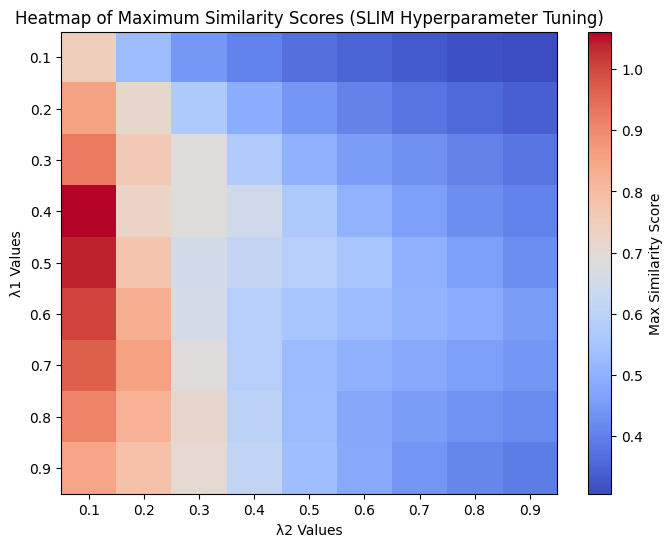

In [14]:
import matplotlib.pyplot as plt

# Initialize a matrix to store similarity values
lambda_1_values = np.round(np.arange(0.1, 1, 0.1),2)
lambda_2_values = np.round(np.arange(0.1, 1, 0.1),2)
similarity_matrix = np.zeros((len(lambda_1_values), len(lambda_2_values)))

# Perform the tuning and store the results
for i, l1_value in enumerate(lambda_1_values):
    for j, l2_value in enumerate(lambda_2_values):
        W, _ = slim_fit(ui_matrix.values, lambda_1=l1_value, lambda_2=l2_value, max_iter=10000)
        max_sim = max(W.flatten())
        similarity_matrix[i, j] = max_sim  # Store the max similarity score

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, interpolation='nearest', cmap='coolwarm', aspect='auto')
plt.colorbar(label="Max Similarity Score")
plt.xticks(np.arange(len(lambda_2_values)), lambda_2_values)  # Set x-axis for lambda_2
plt.yticks(np.arange(len(lambda_1_values)), lambda_1_values)  # Set y-axis for lambda_1
plt.xlabel('λ2 Values')
plt.ylabel('λ1 Values')
plt.title('Heatmap of Maximum Similarity Scores (SLIM Hyperparameter Tuning)')
plt.show()

**`ANALYSIS`**: The greater the value of similarity score is to 1, the greater is the overfitting and the lesser the value, the more is the under fitting! So, the worst combinations are `λ1 = 0.4` <-> `λ2 = 0.1` and `λ1 = 0.1` <-> `λ2 = 0.9`. This tradeoff needs to be implemented as per requirement.

### **3.5 Error comparision on `Cosine` vs `SLIM` Matrices**

In [15]:
R_hat.head()

movieId,13,32,36,39,43,62,146,150,153,157,...,74458,77455,80906,84374,88810,97938,99114,106782,115713,122882
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,6.62671,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,6.30076,0.0,0.0,0.0,0.0,6.30139,0.0,6.29975
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000
5,0.0,0.0,6.96549,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000


In [16]:
ui_matrix.head()

movieId,13,32,36,39,43,62,146,150,153,157,...,74458,77455,80906,84374,88810,97938,99114,106782,115713,122882
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,5.0,0.0,0.0,0.0,3.5,5.0,3.5,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- **Similarity Matrix MSE Error**

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

W, R_hat = slim_fit(ui_matrix.values, lambda_1=0.1, lambda_2=0.1, max_iter=1000)

# Compare with W (learned similarity matrix)
mse_similarity = mean_squared_error(ii_similarity_matrix.values.flatten(), W.flatten())
mae_similarity = mean_absolute_error(ii_similarity_matrix.values.flatten(), W.flatten())

print(f"Mean Squared Error  (Similarity Matrix): {np.round(mse_similarity,5)}")
print(f"Mean Absolute Error (Similarity Matrix): {np.round(mae_similarity,5)}")

Mean Squared Error  (Similarity Matrix): 0.08701
Mean Absolute Error (Similarity Matrix): 0.09645


- **Ranking Matrix MSE Error**

In [18]:
# Mask the original user-item matrix to keep only known ratings
mask = ui_matrix >= 0
true_ratings = ui_matrix[mask]
predicted_ratings = pd.DataFrame(R_hat, index=ui_matrix.index, columns=ui_matrix.columns)[mask]

# Compute MAE or MSE
mae_ratings = np.mean(np.abs(true_ratings - predicted_ratings))
mse_ratings = mean_squared_error(true_ratings, predicted_ratings)
print(f"Mean Absolute Error (Ratings Matrix): {np.round(mae_ratings,5)}")
print(f"Mean Squared Error  (Ratings Matrix): {np.round(mse_ratings,5)}")

Mean Absolute Error (Ratings Matrix): 0.2679
Mean Squared Error  (Ratings Matrix): 0.88007


### **4. Plotting `MSE` Error for `W` and `R_hat` for variations of `λ1` and `λ2`**

In [19]:
def calculate_slim_errors(ui_matrix, ii_similarity_matrix, slim_fit, lambda_1_values, lambda_2_values):
    # Initialize grids to store errors
    mse_similarity_grid = np.zeros((len(lambda_1_values), len(lambda_2_values)))
    mse_rating_grid = np.zeros((len(lambda_1_values), len(lambda_2_values)))

    # Iterate over all combinations of lambda_1 and lambda_2
    for i, lambda_1 in enumerate(lambda_1_values):
        for j, lambda_2 in enumerate(lambda_2_values):
            # Fit the SLIM model
            W, R_hat = slim_fit(ui_matrix.values, lambda_1=lambda_1, lambda_2=lambda_2, max_iter=1000)

            # Compare with ii_similarity_matrix (learned similarity matrix)
            mse_similarity = mean_squared_error(ii_similarity_matrix.values.flatten(), W.flatten())

            # Mask the original user-item matrix to keep only known ratings
            mask = ui_matrix >= 0
            true_ratings = ui_matrix[mask]
            predicted_ratings = pd.DataFrame(R_hat, index=ui_matrix.index, columns=ui_matrix.columns)[mask]

            # Compute MSE for the rating matrix
            mse_ratings = mean_squared_error(true_ratings, predicted_ratings)

            # Store the errors in the grid
            mse_similarity_grid[i, j] = mse_similarity
            mse_rating_grid[i, j] = mse_ratings

    return mse_similarity_grid, mse_rating_grid


In [20]:
# Define the range of lambda_1 and lambda_2 values
lambda_1_values = np.arange(0.1, 1.0, 0.05)
lambda_2_values = np.arange(0.1, 1.0, 0.05)

# Call the function to calculate data points
mse_similarity_grid, mse_rating_grid = calculate_slim_errors(ui_matrix, ii_similarity_matrix, slim_fit, lambda_1_values, lambda_2_values)

In [21]:
import plotly.graph_objects as go

# Create a 3D surface plot for similarity matrix errors
fig = go.Figure()

# Add the first surface for similarity matrix errors
fig.add_trace(go.Surface(
    z=mse_similarity_grid,
    x=lambda_1_values,
    y=lambda_2_values,
    colorscale='Agsunset',
    name="Similarity Matrix MSE(W)",
    showscale=True,
    colorbar=dict(
        title="Similarity MSE",
        x=0.25,  # Position of the colorbar
        len=0.85  # Length of the colorbar
    )
))

# Add the second surface for rating matrix errors
fig.add_trace(go.Surface(
    z=mse_rating_grid,
    x=lambda_1_values,
    y=lambda_2_values,
    colorscale='Aggrnyl',
    name="Rating Matrix MSE(R_hat)",
    showscale=True,
    opacity=0.8,
    colorbar=dict(
        title="Rating MSE",
        x=0.75,  # Position of the colorbar (shifted right)
        len=0.85  # Length of the colorbar
    )
))

# Update layout for better visualization
fig.update_layout(
    title="SLIM Model: 3D Surface Plot of Errors",
    scene=dict(
        xaxis_title='λ1 Values',
        yaxis_title='λ2 Values',
        zaxis_title='Mean Squared Error (MSE)'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the interactive plot
fig.show()


In [22]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape the grids to be 2D arrays (if they are not already)
mse_similarity_grid_reshaped = mse_similarity_grid.reshape(-1, 1)
mse_rating_grid_reshaped = mse_rating_grid.reshape(-1, 1)

# Scale the values between 0 and 1 using MinMaxScaler
mse_similarity_grid_scaled = scaler.fit_transform(mse_similarity_grid_reshaped)
mse_rating_grid_scaled = scaler.fit_transform(mse_rating_grid_reshaped)

# Reshape back to original grid shape
mse_similarity_grid_scaled = mse_similarity_grid_scaled.reshape(len(lambda_1_values), len(lambda_2_values))
mse_rating_grid_scaled = mse_rating_grid_scaled.reshape(len(lambda_1_values), len(lambda_2_values))

In [23]:
import plotly.graph_objects as go

# Create a 3D surface plot for similarity matrix errors
fig = go.Figure()

# Add the first surface for similarity matrix errors
fig.add_trace(go.Surface(
    z=mse_similarity_grid_scaled,
    x=lambda_1_values,
    y=lambda_2_values,
    colorscale='Agsunset',
    name="Similarity Matrix MSE",
    showscale=True,
    colorbar=dict(
        title="Similarity MSE",
        x=0.25,  # Position of the colorbar
        len=0.85  # Length of the colorbar
    )
))

# Add the second surface for rating matrix errors
fig.add_trace(go.Surface(
    z=mse_rating_grid_scaled,
    x=lambda_1_values,
    y=lambda_2_values,
    colorscale='Aggrnyl',
    name="Rating Matrix MSE",
    showscale=True,
    opacity=0.8,
    colorbar=dict(
        title="Rating MSE",
        x=0.75,  # Position of the colorbar (shifted right)
        len=0.85  # Length of the colorbar
    )
))

# Update layout for better visualization
fig.update_layout(
    title="SLIM Model: 3D Surface Plot of Errors",
    scene=dict(
        xaxis_title='λ1 Values',
        yaxis_title='λ2 Values',
        zaxis_title='Mean Squared Error (MSE)'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the interactive plot
fig.show()

- Thus, the plot signifies that **`decrease in Similarity Error`** results in **`decrease in Rating Error`**, thus leading to better **`Rating`** prediction!